### First, let's build some camera calibration.

In [320]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

def get_calibration(calibration_images):

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    img_size = None

    # Step through the list and search for chessboard corners
    for fname in calibration_images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img_size = gray.shape[::-1]

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    return cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

cv2.destroyAllWindows()

We'll create a simple CalibratedCamera class to act as the camera.

In [321]:
import cv2
class CalibratedCamera():

    def __init__(self, ret, mtx, dist, rvecs, tvecs):
        self.ret = ret
        self.mtx = mtx
        self.dist = dist
        self.rvecs = rvecs
        self.tvecs = tvecs

    def undistort_img(self, img):
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)

    def warp_inverse(self, img):
        pass

In [322]:
image_fnames = glob.glob('./camera_cal/calibration*.jpg')
ret, mtx, dist, rvecs, tvecs = get_calibration(image_fnames)


In [323]:
camera = CalibratedCamera(ret, mtx, dist, rvecs, tvecs)

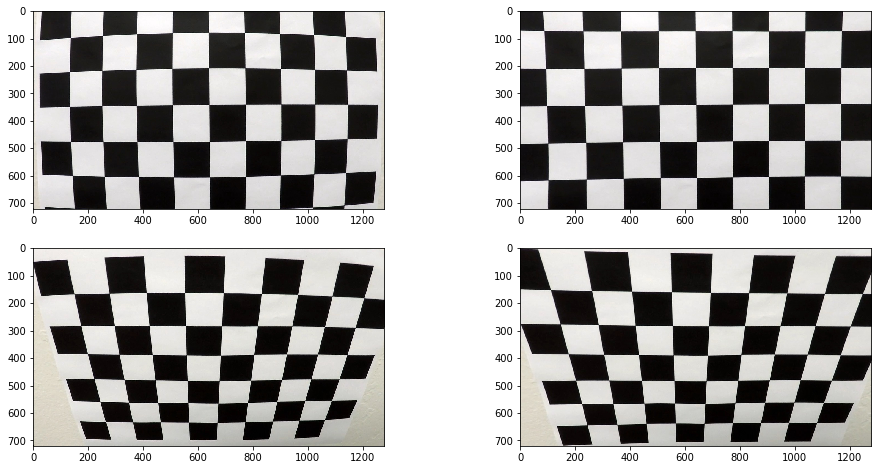

In [324]:
test_img1 = cv2.imread('./camera_cal/calibration1.jpg')
test_img1 = cv2.cvtColor(test_img1, cv2.COLOR_BGR2RGB)
test_img2 = cv2.imread('./camera_cal/calibration2.jpg')
test_img2 = cv2.cvtColor(test_img2, cv2.COLOR_BGR2RGB)
undistored_test_img1 = camera.undistort_img(test_img1)
undistored_test_img2 = camera.undistort_img(test_img2)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
ax = ax.ravel()

ax[0].imshow(test_img1)
ax[1].imshow(undistored_test_img1)
ax[2].imshow(test_img2)
ax[3].imshow(undistored_test_img2)

### Now let's create some tresholding functions to detect lane lines.

In [325]:
import cv2
def abs_sobel_thresh(img_gray, orient='x', thresh_min=0, thresh_max=255):
    if orient == 'x':
        sobel = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1)

    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sbinary
    

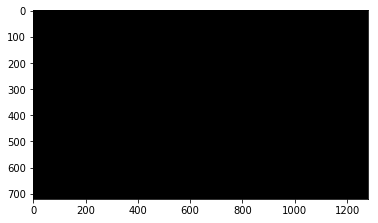

In [326]:
img = cv2.imread('./debug_imgs/img0.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
sobeld = abs_sobel_thresh(gray, orient='y')
plt.imshow(sobeld, cmap='gray')

In [327]:
def mag_thresh(img_gray, sobel_kernel=3, thresh_min=0, thresh_max=255):
    sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh_min) & (gradmag <= thresh_max)] = 1
    return binary_output

In [328]:
def dir_threshold(img_gray, sobel_kernel=3, thresh_min_radian=0, thresh_max_radian=np.pi/2):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh_min_radian) & (absgraddir <= thresh_max_radian)] = 1
    return binary_output

In [329]:
def rgb_thresholds(img_path):
    img = cv2.imread(img_path)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    R = rgb_img[:,:,0]
    G = rgb_img[:,:,1]
    B = rgb_img[:,:,2]
    
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 8))
    ax = ax.ravel()
    
    r_binary = np.zeros_like(R)
    g_binary = np.zeros_like(G)
    b_binary = np.zeros_like(B)
    
    r_binary[(R > 200) & (R <= 255)] = 1
    g_binary[(G > 200) & (G <= 255)] = 1
    b_binary[(B > 200) & (B <= 255)] = 1
    
    ax[0].imshow(R, cmap='gray')
    ax[1].imshow(r_binary, cmap='gray')
    ax[2].imshow(G, cmap='gray')
    ax[3].imshow(g_binary, cmap='gray')
    ax[4].imshow(B, cmap='gray')
    ax[5].imshow(b_binary, cmap='gray')

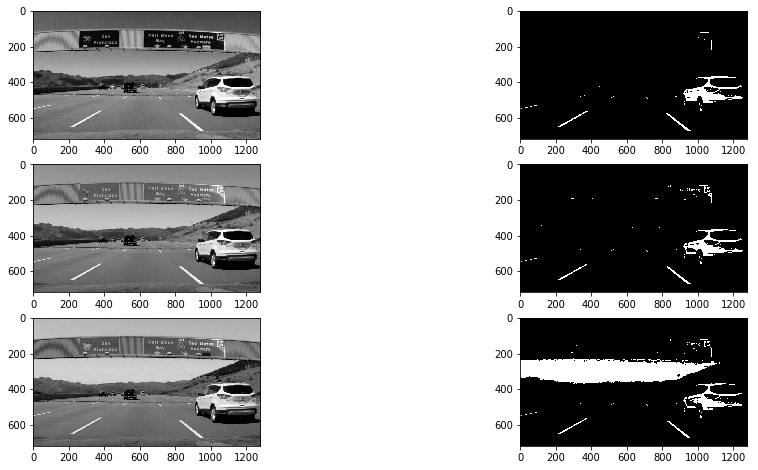

In [330]:
rgb_thresholds('./test_images/signs_vehicles_xygrad.jpg')

### HLS thresholds.

Notice that the L and S layers (2nd and 3rd row) give the best results for vertical (lane) lines. I'll combine the L and S layers in the pipeline to be used for identifying lanes.

In [331]:
def hls_thresholds(img_path):
    img = cv2.imread(img_path)
    hls_img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    H = hls_img[:,:,0]
    L = hls_img[:,:,1]
    S = hls_img[:,:,2]
    
    fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(16, 8))
    ax = ax.ravel()
    
    h_binary = np.zeros_like(H)
    l_binary = np.zeros_like(L)
    s_binary = np.zeros_like(S)
    combined_binary = np.zeros_like(S)
    
    h_binary[(H > 140) & (H <= 180)] = 1
    l_binary[(L > 90) & (L <= 255)] = 1
    s_binary[(S > 90) & (S <= 255)] = 1
    combined_binary[(l_binary == 1) & (s_binary == 1)] = 1
    
    ax[0].imshow(H, cmap='gray')
    ax[1].imshow(h_binary, cmap='gray')
    ax[2].imshow(L, cmap='gray')
    ax[3].imshow(l_binary, cmap='gray')
    ax[4].imshow(S, cmap='gray')
    ax[5].imshow(s_binary, cmap='gray')
    ax[6].imshow(combined_binary, cmap='gray')

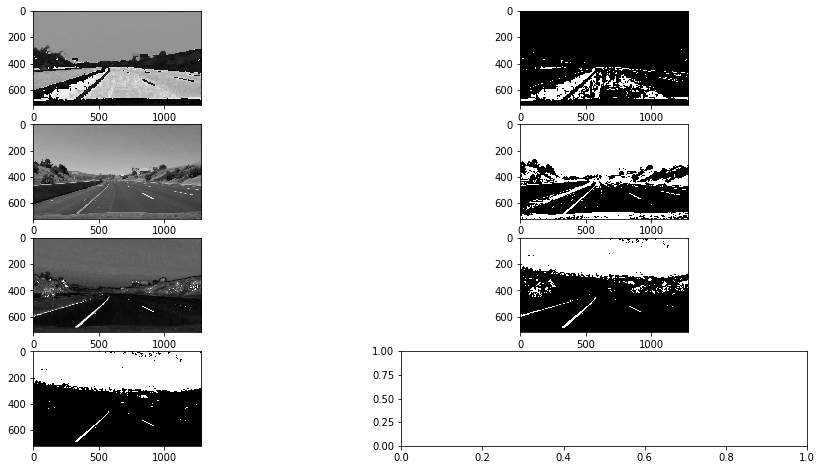

In [332]:
hls_thresholds('./debug_imgs/img0.jpg')

### Perspective transformations.

In [333]:
def apply_perspective(img):
    top_left_src = [570, 468]
    top_right_src = [714, 468]
    bottom_right_src = [1106, 720]
    bottom_left_src = [207, 720]
    
    top_left_dst = [320, 1]
    top_right_dst = [920, 1]
    bottom_right_dst = [920, 720]
    bottom_left_dst = [320, 720]
    
    src = np.array([top_left_src, top_right_src, bottom_right_src, bottom_left_src], np.float32)
    dst = np.float32([top_left_dst ,top_right_dst, bottom_right_dst, bottom_left_dst])
                       
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0])), Minv

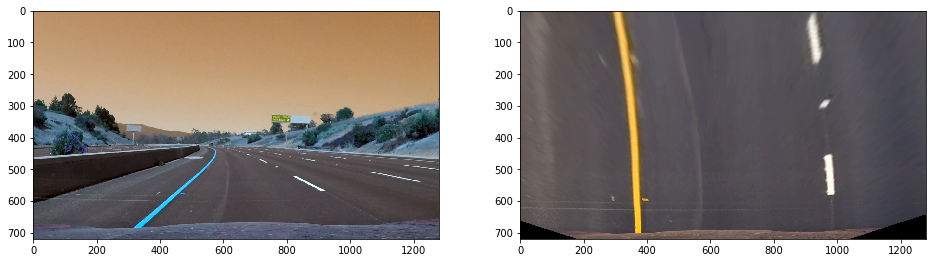

In [334]:
img = cv2.imread('./debug_imgs/img0.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
transformed, _ = apply_perspective(img)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
ax = ax.ravel()

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
ax[0].imshow(img)
ax[1].imshow(transformed)

In [335]:
import math
def test_run(img_path, sobel_kernel=11, thresh_min=40, thresh_max=150):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    undistored = camera.undistort_img(gray)
    
    gradx = abs_sobel_thresh(gray, orient='x', thresh_min=50, thresh_max=150)
    grady = abs_sobel_thresh(gray, orient='y', thresh_min=50, thresh_max=150)
    mag_binary = mag_thresh(gray, sobel_kernel=sobel_kernel, thresh_min=10, thresh_max=150)
    min_radian = 0.7
    max_radian = 1.3
    dir_binary = dir_threshold(gray, sobel_kernel=sobel_kernel, thresh_min_radian=min_radian, thresh_max_radian=max_radian)
    
    combined = np.zeros_like(dir_binary)
    combined[((grady == 1) & (dir_binary == 1) & (mag_binary == 1))] = 1
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
    ax = ax.ravel()

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[0].imshow(img)
    ax[1].imshow(combined, cmap='gray')


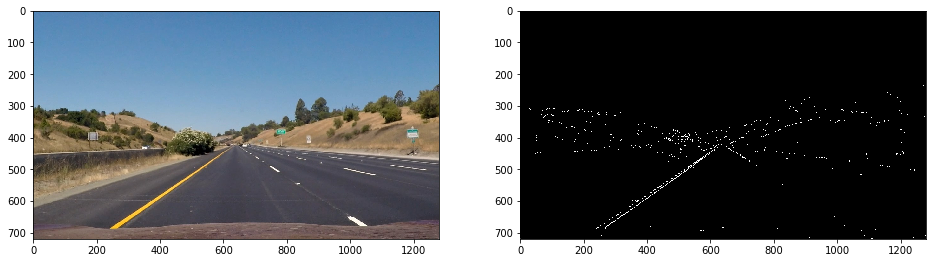

In [16]:
test_run('./test_images/straight_lines1.jpg')

In [336]:
def apply_thresholds(img_rgb, sobel_kernel=9):
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    gradx = abs_sobel_thresh(gray, orient='x', thresh_min=50, thresh_max=150)
    grady = abs_sobel_thresh(gray, orient='y', thresh_min=50, thresh_max=150)
    mag_binary = mag_thresh(gray, sobel_kernel=sobel_kernel, thresh_min=30, thresh_max=150)
    min_radian = 0.7
    max_radian = 1.3
    dir_binary = dir_threshold(gray, sobel_kernel=sobel_kernel, thresh_min_radian=min_radian, thresh_max_radian=max_radian)
    
    combined = np.zeros_like(dir_binary)
    combined[((grady == 1) & (dir_binary == 1) & (mag_binary == 1))] = 1
    
    hls_img = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)
    S = hls_img[:,:,2]
    L = hls_img[:,:,1]
    
    s_binary = np.zeros_like(S)
    l_binary = np.zeros_like(L)
    ls_binary = np.zeros_like(L)
    s_binary[(S > 90) & (S <= 255)] = 1
    l_binary[(L > 90) & (L <= 255)] = 1
    ls_binary[(l_binary == 1) & (s_binary == 1)] = 1
    
    result = np.zeros_like(combined)
    result[(ls_binary == 1)] = 1
    return result
    

### Create a pipeline for image processing.

It will carry out undistorting the image, apply perspective transform and then finally performing some binary thresholding.

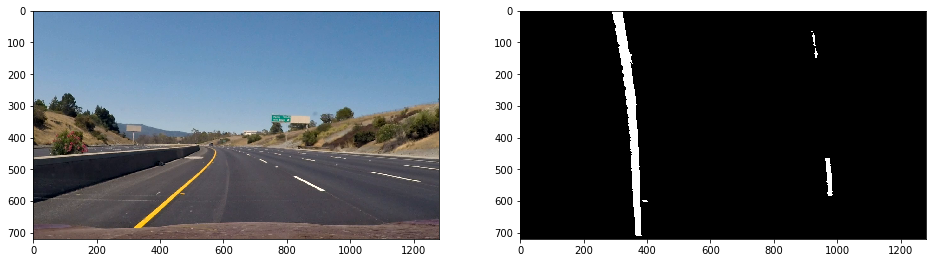

In [337]:
def pipeline(img):
    undistored = camera.undistort_img(img)
    transformed, Minv = apply_perspective(undistored)
    binaried = apply_thresholds(transformed)
    return binaried, Minv

img = cv2.imread('./debug_imgs/img0.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pipelined, _ = pipeline(img)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
ax = ax.ravel()

ax[0].imshow(img)
ax[1].imshow(pipelined, cmap='gray')

In [338]:
import numpy as np
import cv2


def apply_sliding_window(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2) if leftx.any() else None
    right_fit = np.polyfit(righty, rightx, 2) if rightx.any() else None
    
    return left_fit, right_fit, out_img, left_lane_inds, right_lane_inds


In [339]:
def fit_using_previous_fit(binary_warped, previous_left_fit, previous_right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    
    left_lane_inds = ((nonzerox > (previous_left_fit[0]*(nonzeroy**2) + previous_left_fit[1]*nonzeroy + previous_left_fit[2] - margin)) & 
                      (nonzerox < (previous_left_fit[0]*(nonzeroy**2) + previous_left_fit[1]*nonzeroy + previous_left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (previous_right_fit[0]*(nonzeroy**2) + previous_right_fit[1]*nonzeroy + previous_right_fit[2] - margin)) & 
                       (nonzerox < (previous_right_fit[0]*(nonzeroy**2) + previous_right_fit[1]*nonzeroy + previous_right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, None, left_lane_inds, right_lane_inds

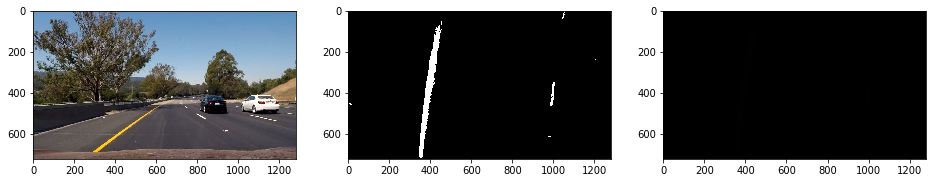

In [340]:
img = cv2.imread('./test_images/test6.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pipelined, Minv = pipeline(img)
left_fit, right_fit, out_img, left_lane_inds, right_lane_inds = apply_sliding_window(pipelined)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
ax = ax.ravel()

ax[0].imshow(img)
ax[1].imshow(pipelined, cmap='gray')
ax[2].imshow(out_img)

In [341]:
def measure_curvature(binary_warped, left_lane_inds, right_lane_inds):
    height = binary_warped.shape[0]
    ploty = np.linspace(0, height - 1, num=height)

    # Find X and Y positions of non-zeros
    nonzero = binary_warped.nonzero()
    nonzero_x = np.array(nonzero[1])
    nonzero_y = np.array(nonzero[0])
    
    leftx = nonzero_x[left_lane_inds]
    lefty = nonzero_y[left_lane_inds]
    rightx = nonzero_x[right_lane_inds]
    righty = nonzero_y[right_lane_inds]
    
    if len(leftx) and len(rightx):
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        y_eval = np.max(ploty)
        
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        return left_curverad, right_curverad
    return 0.0, 0.0

In [342]:
img = cv2.imread('./test_images/signs_vehicles_xygrad.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

pipelined, Minv = pipeline(img)
left_fit, right_fit, out_img, left_lane_inds, right_lane_inds = apply_sliding_window(pipelined)
left_curve, right_curve = measure_curvature(pipelined, left_lane_inds, right_lane_inds)

In [343]:
print(left_curve, right_curve)

12583.7257384 2416.65041314


### Define the drawing functions for drawing the lane path and the debug text.

In [344]:
def draw(warped, original, left_fit, right_fit, Minv):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    h = warped.shape[0]
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original.shape[1], original.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original, 1, newwarp, 0.3, 0)
    return result

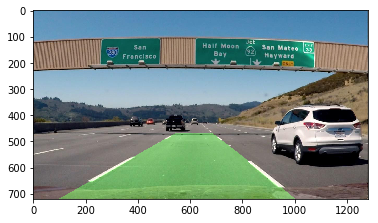

In [345]:
result = draw(pipelined, img, left_fit, right_fit, Minv)
plt.imshow(result)

In [346]:
def draw_text(img, left_curve, right_curve, left_fit, right_fit):
    car_position = img.shape[1]/2
    height = img.shape[0]
    leftx_intercept = left_fit[0]*height**2 + left_fit[1]*height + left_fit[2]
    rightx_intercept = right_fit[0]*height**2 + right_fit[1]*height + right_fit[2]
    center = (rightx_intercept + leftx_intercept) /2
    center_dist = (car_position - center) * 3.7/700
    curve = (left_curve + right_curve) / 2
        
    result = np.copy(img)
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Radius: ' + '{:04.2f}'.format(curve) + 'm'
    cv2.putText(result, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(result, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return result

### A simple Line class for averaging over the last 5 runs.

In [347]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.past_fits = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 

    def add(self, fit):
        if fit is None:
            self.detected = None
            if len(self.past_fits) > 0:
                self.past_fits = self.past_fits[-5:]
                if len(self.past_fits) > 0:
                    self.best_fit = np.average(self.past_fits, axis=0)

        if self.best_fit is None:
            self.best_fit = fit
            self.detected = True

        if fit is not None and self.best_fit is not None:
            self.diffs = abs(self.best_fit - fit)
            if not self._is_within_threshold(fit) and len(self.past_fits) > 0:
                self.detected = False
            elif self._is_within_threshold(fit):
                self.past_fits.append(fit)
                self.detected = True
                if len(self.past_fits) > 5:
                    self.past_fits = self.past_fits[-5:]
                self.best_fit = np.average(self.past_fits, axis=0)
            
        
    def _is_within_threshold(self, fit):
        return self.diffs[0] < 0.01 and self.diffs[1] < 1.0 and self.diffs[2] < 100.0

### Combine it all together!

In [348]:
binaried_imgs = []
original_imgs = []
prev_left_curve, prev_right_curve = 0.0, 0.0
def process_image(img):
    global prev_left_curve
    global prev_right_curve
    binaried, Minv = pipeline(img)
    if left_line.detected and right_line.detected:
        left_fit, right_fit, out_img, left_lane_inds, right_lane_inds = fit_using_previous_fit(
            binaried, left_line.best_fit, right_line.best_fit)
    else:
        left_fit, right_fit, out_img, left_lane_inds, right_lane_inds = apply_sliding_window(binaried)
        binaried_imgs.append(binaried)
        original_imgs.append(img)
    left_line.add(left_fit)
    right_line.add(right_fit)
    
    if left_line.best_fit is not None and right_line.best_fit is not None:
        if len(left_lane_inds) is 0 or len(right_lane_inds) is 0:
            left_curve, right_curve = prev_left_curve, prev_right_curve
        else:
            left_curve, right_curve = measure_curvature(binaried, left_lane_inds, right_lane_inds)
        prev_left_curve, prev_right_curve = left_curve, right_curve
        result = draw(binaried, img, left_line.best_fit, right_line.best_fit, Minv)
        result = draw_text(result, left_curve, right_curve, left_line.best_fit, right_line.best_fit)
    else:
        result = img
    return result

### Finally, create the video!

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing audio in project_video_outputTEMP_MPY_wvf_snd.mp3






  0%|          | 0/1112 [00:00<?, ?it/s]



  8%|▊         | 84/1112 [00:00<00:01, 837.33it/s]



 17%|█▋        | 184/1112 [00:00<00:01, 878.49it/s]



 25%|██▌       | 283/1112 [00:00<00:00, 906.67it/s]



 34%|███▍      | 383/1112 [00:00<00:00, 929.37it/s]



 43%|████▎     | 482/1112 [00:00<00:00, 944.33it/s]



 52%|█████▏    | 579/1112 [00:00<00:00, 951.49it/s]



 61%|██████    | 677/1112 [00:00<00:00, 956.85it/s]



 69%|██████▉   | 770/1112 [00:00<00:00, 945.34it/s]



 77%|███████▋  | 860/1112 [00:00<00:00, 905.91it/s]



 86%|████████▌ | 951/1112 [00:01<00:00, 903.89it/s]



 95%|█████████▍| 1051/1112 [00:01<00:00, 923.01it/s]



100%|██████████| 1112/1112 [00:01<00:00, 939.66it/s]

[MoviePy] Done.
[MoviePy] Writing video project_video_output.mp4






  0%|          | 0/1261 [00:00<?, ?it/s]



  0%|          | 1/1261 [00:00<05:17,  3.97it/s]



  0%|          | 2/1261 [00:00<05:15,  3.99it/s]



  0%|          | 3/1261 [00:00<05:15,  3.99it/s]



  0%|          | 4/1261 [00:01<05:17,  3.96it/s]



  0%|          | 5/1261 [00:01<05:18,  3.94it/s]



  0%|          | 6/1261 [00:01<05:21,  3.90it/s]



  1%|          | 7/1261 [00:01<05:21,  3.90it/s]



  1%|          | 8/1261 [00:02<05:16,  3.96it/s]



  1%|          | 9/1261 [00:02<05:14,  3.98it/s]



  1%|          | 10/1261 [00:02<05:12,  4.00it/s]



  1%|          | 11/1261 [00:02<05:19,  3.91it/s]



  1%|          | 12/1261 [00:03<05:16,  3.95it/s]



  1%|          | 13/1261 [00:03<05:11,  4.00it/s]



  1%|          | 14/1261 [00:03<05:10,  4.02it/s]



  1%|          | 15/1261 [00:03<05:28,  3.79it/s]



  1%|▏         | 16/1261 [00:04<05:41,  3.65it/s]



  1%|▏         | 17/1261 [00:04<05:45,  3.60it/s]



  1%|▏         | 18/1261 [00:04<05:41,  3.64it/s]



  2%|▏ 

 10%|▉         | 125/1261 [00:35<05:14,  3.61it/s]



 10%|▉         | 126/1261 [00:36<05:05,  3.71it/s]



 10%|█         | 127/1261 [00:36<04:56,  3.82it/s]



 10%|█         | 128/1261 [00:36<05:09,  3.66it/s]



 10%|█         | 129/1261 [00:36<05:20,  3.53it/s]



 10%|█         | 130/1261 [00:37<05:22,  3.50it/s]



 10%|█         | 131/1261 [00:37<05:11,  3.63it/s]



 10%|█         | 132/1261 [00:37<05:03,  3.72it/s]



 11%|█         | 133/1261 [00:37<05:03,  3.72it/s]



 11%|█         | 134/1261 [00:38<05:09,  3.65it/s]



 11%|█         | 135/1261 [00:38<05:25,  3.46it/s]



 11%|█         | 136/1261 [00:38<05:42,  3.29it/s]



 11%|█         | 137/1261 [00:39<05:42,  3.28it/s]



 11%|█         | 138/1261 [00:39<05:44,  3.26it/s]



 11%|█         | 139/1261 [00:39<05:43,  3.27it/s]



 11%|█         | 140/1261 [00:40<05:44,  3.25it/s]



 11%|█         | 141/1261 [00:40<05:42,  3.27it/s]



 11%|█▏        | 142/1261 [00:40<05:49,  3.20it/s]



 11%|█▏        | 143/1261 [0

 20%|█▉        | 249/1261 [01:09<04:16,  3.95it/s]



 20%|█▉        | 250/1261 [01:09<04:15,  3.96it/s]



 20%|█▉        | 251/1261 [01:09<04:11,  4.01it/s]



 20%|█▉        | 252/1261 [01:10<04:13,  3.98it/s]



 20%|██        | 253/1261 [01:10<04:11,  4.01it/s]



 20%|██        | 254/1261 [01:10<04:16,  3.92it/s]



 20%|██        | 255/1261 [01:10<04:18,  3.88it/s]



 20%|██        | 256/1261 [01:11<04:39,  3.60it/s]



 20%|██        | 257/1261 [01:11<04:45,  3.52it/s]



 20%|██        | 258/1261 [01:11<04:38,  3.61it/s]



 21%|██        | 259/1261 [01:12<04:29,  3.71it/s]



 21%|██        | 260/1261 [01:12<04:24,  3.78it/s]



 21%|██        | 261/1261 [01:12<04:17,  3.88it/s]



 21%|██        | 262/1261 [01:12<04:14,  3.93it/s]



 21%|██        | 263/1261 [01:13<04:14,  3.92it/s]



 21%|██        | 264/1261 [01:13<04:22,  3.80it/s]



 21%|██        | 265/1261 [01:13<04:17,  3.87it/s]



 21%|██        | 266/1261 [01:13<04:26,  3.73it/s]



 21%|██        | 267/1261 [0

 30%|██▉       | 373/1261 [01:42<07:16,  2.03it/s]



 30%|██▉       | 374/1261 [01:42<07:01,  2.11it/s]



 30%|██▉       | 375/1261 [01:42<06:02,  2.45it/s]



 30%|██▉       | 376/1261 [01:43<05:48,  2.54it/s]



 30%|██▉       | 377/1261 [01:43<05:35,  2.64it/s]



 30%|██▉       | 378/1261 [01:44<06:36,  2.22it/s]



 30%|███       | 379/1261 [01:44<05:49,  2.52it/s]



 30%|███       | 380/1261 [01:44<05:54,  2.49it/s]



 30%|███       | 381/1261 [01:45<05:21,  2.74it/s]



 30%|███       | 382/1261 [01:45<04:56,  2.96it/s]



 30%|███       | 383/1261 [01:45<04:37,  3.17it/s]



 30%|███       | 384/1261 [01:45<04:20,  3.36it/s]



 31%|███       | 385/1261 [01:46<04:07,  3.54it/s]



 31%|███       | 386/1261 [01:46<04:34,  3.19it/s]



 31%|███       | 387/1261 [01:46<04:34,  3.19it/s]



 31%|███       | 388/1261 [01:47<04:17,  3.39it/s]



 31%|███       | 389/1261 [01:47<04:07,  3.53it/s]



 31%|███       | 390/1261 [01:47<04:02,  3.59it/s]



 31%|███       | 391/1261 [0

 39%|███▉      | 497/1261 [02:17<03:34,  3.57it/s]



 39%|███▉      | 498/1261 [02:18<03:37,  3.50it/s]



 40%|███▉      | 499/1261 [02:18<03:32,  3.59it/s]



 40%|███▉      | 500/1261 [02:18<03:25,  3.70it/s]



 40%|███▉      | 501/1261 [02:18<03:21,  3.77it/s]



 40%|███▉      | 502/1261 [02:19<03:20,  3.79it/s]



 40%|███▉      | 503/1261 [02:19<03:17,  3.83it/s]



 40%|███▉      | 504/1261 [02:19<03:18,  3.81it/s]



 40%|████      | 505/1261 [02:19<03:15,  3.87it/s]



 40%|████      | 506/1261 [02:20<03:34,  3.52it/s]



 40%|████      | 507/1261 [02:20<04:29,  2.80it/s]



 40%|████      | 508/1261 [02:21<04:22,  2.87it/s]



 40%|████      | 509/1261 [02:21<04:11,  2.99it/s]



 40%|████      | 510/1261 [02:21<03:58,  3.14it/s]



 41%|████      | 511/1261 [02:21<03:47,  3.30it/s]



 41%|████      | 512/1261 [02:22<03:52,  3.22it/s]



 41%|████      | 513/1261 [02:22<04:01,  3.10it/s]



 41%|████      | 514/1261 [02:23<04:50,  2.57it/s]



 41%|████      | 515/1261 [0

 49%|████▉     | 621/1261 [02:53<02:56,  3.62it/s]



 49%|████▉     | 622/1261 [02:54<02:57,  3.59it/s]



 49%|████▉     | 623/1261 [02:54<02:56,  3.61it/s]



 49%|████▉     | 624/1261 [02:54<02:58,  3.56it/s]



 50%|████▉     | 625/1261 [02:54<02:57,  3.58it/s]



 50%|████▉     | 626/1261 [02:55<02:55,  3.62it/s]



 50%|████▉     | 627/1261 [02:55<02:54,  3.64it/s]



 50%|████▉     | 628/1261 [02:55<02:55,  3.60it/s]



 50%|████▉     | 629/1261 [02:55<02:55,  3.59it/s]



 50%|████▉     | 630/1261 [02:56<02:54,  3.63it/s]



 50%|█████     | 631/1261 [02:56<02:58,  3.52it/s]



 50%|█████     | 632/1261 [02:56<02:54,  3.61it/s]



 50%|█████     | 633/1261 [02:57<02:48,  3.73it/s]



 50%|█████     | 634/1261 [02:57<02:43,  3.85it/s]



 50%|█████     | 635/1261 [02:57<02:38,  3.95it/s]



 50%|█████     | 636/1261 [02:57<02:45,  3.77it/s]



 51%|█████     | 637/1261 [02:58<02:41,  3.87it/s]



 51%|█████     | 638/1261 [02:58<02:36,  3.97it/s]



 51%|█████     | 639/1261 [0

 59%|█████▉    | 745/1261 [03:26<02:09,  3.98it/s]



 59%|█████▉    | 746/1261 [03:27<02:08,  4.02it/s]



 59%|█████▉    | 747/1261 [03:27<02:09,  3.98it/s]



 59%|█████▉    | 748/1261 [03:27<02:15,  3.79it/s]



 59%|█████▉    | 749/1261 [03:27<02:15,  3.79it/s]



 59%|█████▉    | 750/1261 [03:28<02:14,  3.79it/s]



 60%|█████▉    | 751/1261 [03:28<02:19,  3.66it/s]



 60%|█████▉    | 752/1261 [03:28<02:32,  3.35it/s]



 60%|█████▉    | 753/1261 [03:29<02:31,  3.36it/s]



 60%|█████▉    | 754/1261 [03:29<02:28,  3.42it/s]



 60%|█████▉    | 755/1261 [03:29<02:26,  3.46it/s]



 60%|█████▉    | 756/1261 [03:30<02:34,  3.26it/s]



 60%|██████    | 757/1261 [03:30<02:28,  3.39it/s]



 60%|██████    | 758/1261 [03:30<02:23,  3.51it/s]



 60%|██████    | 759/1261 [03:30<02:16,  3.68it/s]



 60%|██████    | 760/1261 [03:31<02:14,  3.73it/s]



 60%|██████    | 761/1261 [03:31<02:13,  3.75it/s]



 60%|██████    | 762/1261 [03:31<02:11,  3.80it/s]



 61%|██████    | 763/1261 [0

 69%|██████▉   | 869/1261 [04:00<02:28,  2.64it/s]



 69%|██████▉   | 870/1261 [04:01<02:23,  2.72it/s]



 69%|██████▉   | 871/1261 [04:01<02:21,  2.76it/s]



 69%|██████▉   | 872/1261 [04:01<02:18,  2.82it/s]



 69%|██████▉   | 873/1261 [04:02<02:15,  2.85it/s]



 69%|██████▉   | 874/1261 [04:02<02:10,  2.97it/s]



 69%|██████▉   | 875/1261 [04:02<02:05,  3.08it/s]



 69%|██████▉   | 876/1261 [04:03<02:11,  2.93it/s]



 70%|██████▉   | 877/1261 [04:03<02:09,  2.98it/s]



 70%|██████▉   | 878/1261 [04:03<02:05,  3.05it/s]



 70%|██████▉   | 879/1261 [04:04<02:07,  2.99it/s]



 70%|██████▉   | 880/1261 [04:04<02:04,  3.07it/s]



 70%|██████▉   | 881/1261 [04:04<02:01,  3.13it/s]



 70%|██████▉   | 882/1261 [04:05<02:05,  3.02it/s]



 70%|███████   | 883/1261 [04:05<02:08,  2.95it/s]



 70%|███████   | 884/1261 [04:05<02:04,  3.03it/s]



 70%|███████   | 885/1261 [04:06<02:02,  3.07it/s]



 70%|███████   | 886/1261 [04:06<02:09,  2.90it/s]



 70%|███████   | 887/1261 [0

 79%|███████▊  | 993/1261 [04:36<01:07,  3.96it/s]



 79%|███████▉  | 994/1261 [04:36<01:08,  3.91it/s]



 79%|███████▉  | 995/1261 [04:36<01:07,  3.92it/s]



 79%|███████▉  | 996/1261 [04:36<01:07,  3.94it/s]



 79%|███████▉  | 997/1261 [04:37<01:06,  3.94it/s]



 79%|███████▉  | 998/1261 [04:37<01:08,  3.86it/s]



 79%|███████▉  | 999/1261 [04:37<01:07,  3.89it/s]



 79%|███████▉  | 1000/1261 [04:37<01:06,  3.92it/s]



 79%|███████▉  | 1001/1261 [04:38<01:05,  3.97it/s]



 79%|███████▉  | 1002/1261 [04:38<01:05,  3.94it/s]



 80%|███████▉  | 1003/1261 [04:38<01:06,  3.88it/s]



 80%|███████▉  | 1004/1261 [04:38<01:05,  3.91it/s]



 80%|███████▉  | 1005/1261 [04:39<01:04,  3.94it/s]



 80%|███████▉  | 1006/1261 [04:39<01:05,  3.89it/s]



 80%|███████▉  | 1007/1261 [04:39<01:05,  3.89it/s]



 80%|███████▉  | 1008/1261 [04:40<01:04,  3.93it/s]



 80%|████████  | 1009/1261 [04:40<01:03,  3.94it/s]



 80%|████████  | 1010/1261 [04:40<01:05,  3.86it/s]



 80%|████████  | 

 88%|████████▊ | 1115/1261 [05:07<00:36,  3.99it/s]



 89%|████████▊ | 1116/1261 [05:08<00:38,  3.77it/s]



 89%|████████▊ | 1117/1261 [05:08<00:39,  3.68it/s]



 89%|████████▊ | 1118/1261 [05:08<00:39,  3.61it/s]



 89%|████████▊ | 1119/1261 [05:09<00:40,  3.54it/s]



 89%|████████▉ | 1120/1261 [05:09<00:40,  3.52it/s]



 89%|████████▉ | 1121/1261 [05:09<00:40,  3.49it/s]



 89%|████████▉ | 1122/1261 [05:09<00:40,  3.47it/s]



 89%|████████▉ | 1123/1261 [05:10<00:38,  3.55it/s]



 89%|████████▉ | 1124/1261 [05:10<00:37,  3.64it/s]



 89%|████████▉ | 1125/1261 [05:10<00:36,  3.73it/s]



 89%|████████▉ | 1126/1261 [05:11<00:35,  3.81it/s]



 89%|████████▉ | 1127/1261 [05:11<00:34,  3.85it/s]



 89%|████████▉ | 1128/1261 [05:11<00:34,  3.88it/s]



 90%|████████▉ | 1129/1261 [05:11<00:37,  3.49it/s]



 90%|████████▉ | 1130/1261 [05:12<00:37,  3.54it/s]



 90%|████████▉ | 1131/1261 [05:12<00:36,  3.59it/s]



 90%|████████▉ | 1132/1261 [05:12<00:34,  3.69it/s]



 90%|█████

 98%|█████████▊| 1237/1261 [05:42<00:05,  4.16it/s]



 98%|█████████▊| 1238/1261 [05:42<00:05,  4.17it/s]



 98%|█████████▊| 1239/1261 [05:43<00:05,  3.86it/s]



 98%|█████████▊| 1240/1261 [05:43<00:05,  3.88it/s]



 98%|█████████▊| 1241/1261 [05:43<00:05,  3.97it/s]



 98%|█████████▊| 1242/1261 [05:43<00:04,  3.97it/s]



 99%|█████████▊| 1243/1261 [05:44<00:04,  3.94it/s]



 99%|█████████▊| 1244/1261 [05:44<00:04,  3.87it/s]



 99%|█████████▊| 1245/1261 [05:44<00:04,  3.70it/s]



 99%|█████████▉| 1246/1261 [05:45<00:04,  3.60it/s]



 99%|█████████▉| 1247/1261 [05:45<00:03,  3.70it/s]



 99%|█████████▉| 1248/1261 [05:45<00:03,  3.80it/s]



 99%|█████████▉| 1249/1261 [05:45<00:03,  3.86it/s]



 99%|█████████▉| 1250/1261 [05:46<00:02,  3.90it/s]



 99%|█████████▉| 1251/1261 [05:46<00:02,  3.93it/s]



 99%|█████████▉| 1252/1261 [05:46<00:02,  3.91it/s]



 99%|█████████▉| 1253/1261 [05:46<00:02,  3.96it/s]



 99%|█████████▉| 1254/1261 [05:47<00:01,  3.80it/s]



100%|█████

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



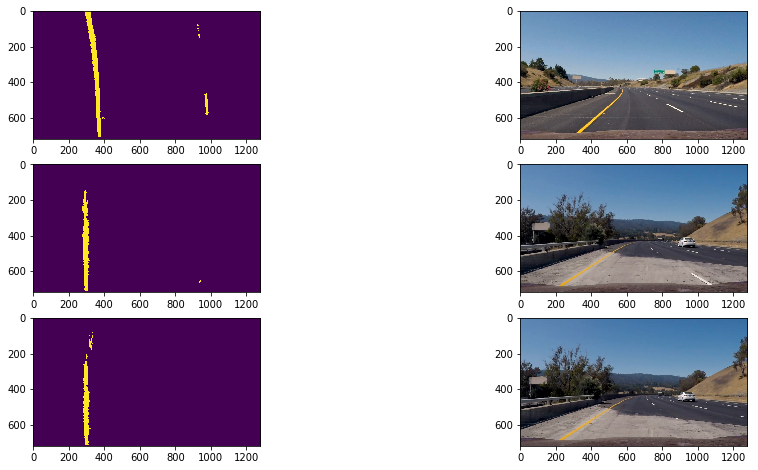

In [319]:
from moviepy.editor import VideoFileClip

binaried_imgs = []
original_imgs = []
prev_left_curve, prev_right_curve = 0.0, 0.0
left_line = Line()
right_line = Line()
video_output = 'project_video_output.mp4'
video_input = VideoFileClip('project_video.mp4')
video = video_input.fl_image(process_image)
video.write_videofile(video_output)

if len(binaried_imgs) > 6:
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 8))
    ax = ax.ravel()
    for idx in range(0, 5, 2):
        plt.imsave('./debug_imgs/img%s.jpg' % idx, original_imgs[idx])
        ax[idx].imshow(binaried_imgs[idx])
        ax[idx+1].imshow(original_imgs[idx])